# Lab2 AutoML for Classification

<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

This is a copy of the test set of the **UCI ML hand-written digits datasets** http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where each class refers to a digit.



<img src="https://www.seewald.at/img/L/digits.gif">


## Documentation
> https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-automated-ml

## 1. Informations

As part of the setup you have already created an Azure ML `Workspace` object. <br> For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-11-17 08:12:26.317327


In [3]:
import azureml.core
print("Azure ML :", azureml.core.VERSION)

Azure ML : 1.18.0


In [4]:
import logging
import os
import random

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

## 2. Experiment

In [5]:
ws = Workspace.from_config()

experiment_name = 'Lab2-AutoML'

project_folder = './sample_projects/lab2'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
SDK version,1.18.0
Workspace Name,AMLworkshop
Resource Group,AMLworkshop-rg
Location,westeurope
Project Directory,./sample_projects/lab2
Experiment Name,Lab2-AutoML


## 3. Loading the dataset

This uses scikit-learn's [load_digits](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) method.

Each datapoint is a 8x8 image of a digit.

In [6]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

In [8]:
print("Dataset Size:", digits.data.shape)

Dataset Size: (1797, 64)


In [9]:
def view(number):
    import matplotlib.pyplot as plt 
    plt.gray() 
    plt.matshow(digits.images[number]) 
    plt.show() 

<Figure size 432x288 with 0 Axes>

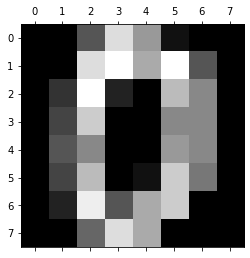

In [10]:
view(0)

<Figure size 432x288 with 0 Axes>

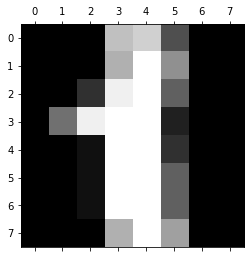

In [11]:
view(1)

<Figure size 432x288 with 0 Axes>

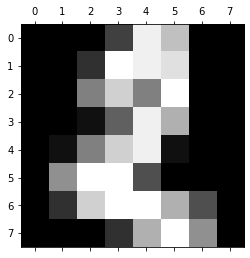

In [12]:
view(2)

<Figure size 432x288 with 0 Axes>

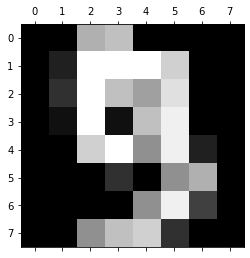

In [13]:
view(9)

## 4. AutoML configuration



In [14]:
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automlclassif.log',
                             primary_metric = 'AUC_weighted', #the metric I want to use
                             iteration_timeout_minutes = 2, #Timeout for each iteration
                             experiment_timeout_minutes = 15, #timeout for the whole process
                             enable_early_stopping=True, 
                             iterations = 10,           # number of max iterations
                             n_cross_validations = 3,    
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

WARNING - The AutoMLConfig parameters, X and y, will soon be deprecated. Please refer to our documentation for the latest interface: https://aka.ms/AutoMLConfig


## 5. AutoML

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

`AUC_weighted` is the **metric** used.

In [15]:
#Mise à jour si besoin (redémarrer le kernel ensuite)
#!pip install --upgrade azureml-sdk[automl]
#!pip install --upgrade azureml-sdk[explain,contrib]
#!pip install interpret-community==0.14.3

## Let's run the process in a local machine (ie your compute instance)

In [16]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing f

## Let's access to the experiment page

In [17]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
Lab2-AutoML,AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


## 6. AutoML results

### 6.1 AutoML Widget for interactive results from the notebook

In [18]:
from azureml.widgets import RunDetails
RunDetails(local_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

### 6.2 Metrics for each iterations of the AutoML

In [19]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
AUC_macro,1.00,1.00,1.00,0.99,0.99,1.00,0.99,0.99,1.00,1.00
precision_score_weighted,0.96,0.96,0.98,0.88,0.93,0.94,0.92,0.96,0.98,0.98
precision_score_micro,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98
recall_score_weighted,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98
average_precision_score_micro,0.99,0.99,1.00,0.94,0.97,0.98,0.97,0.98,1.00,1.00
weighted_accuracy,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98
AUC_micro,1.00,1.00,1.00,0.99,0.99,1.00,1.00,0.99,1.00,1.00
recall_score_macro,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98
f1_score_micro,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98
f1_score_weighted,0.96,0.96,0.98,0.87,0.93,0.94,0.92,0.96,0.98,0.98


## 7. We want to retrieve the best model

In [20]:
best_run, fitted_model = local_run.get_output()

print("Best run =", best_run)

Best run = Run(Experiment: Lab2-AutoML,
Id: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9_8,
Type: None,
Status: Completed)


In [21]:
print(fitted_model)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                    max_features='log2',
                                                                                                    max_leaf_nodes=None,
                                                                                                    max_samples=None,
                                

In [22]:
fitted_model.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                    max_features='log2',
                                                                                                    max_leaf_nodes=None,
                                                                                                    max_samples=N

In [23]:
fitted_model.steps

[('datatransformer',
  DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                  feature_sweeping_config=None, feature_sweeping_timeout=None,
                  featurization_config=None, force_text_dnn=None,
                  is_cross_validation=None, is_onnx_compatible=None, logger=None,
                  observer=None, task=None, working_dir=None)),
 ('prefittedsoftvotingclassifier',
  PreFittedSoftVotingClassifier(classification_labels=None,
                                estimators=[('0',
                                             Pipeline(memory=None,
                                                      steps=[('maxabsscaler',
                                                              MaxAbsScaler(copy=True)),
                                                             ('lightgbmclassifier',
                                                              LightGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_type='split',
                                                                                 learning_rate=0.1,
                                                                                 max_depth=-1,
                                                                                 min_child_samples=20,
                                                                                 min_child_weight=0.001,
                                                                                 min_spl...
                                                                                     max_depth=None,
                                                                                     max_features='log2',
                                                                                     max_leaf_nodes=None,
                                                                                     max_samples=None,
                                                                                     min_impurity_decrease=0.0,
                                                                                     min_impurity_split=None,
                                                                                     min_samples_leaf=0.01,
                                                                                     min_samples_split=0.01,
                                                                                     min_weight_fraction_leaf=0.0,
                                                                                     n_estimators=10,
                                                                                     n_jobs=1,
                                                                                     oob_score=False,
                                                                                     random_state=None,
                                                                                     verbose=0,
                                                                                     warm_start=False))],
                                                      verbose=False))],
                                flatten_transform=None,
                                weights=[0.1, 0.3, 0.4, 0.1, 0.1]))]

In [24]:
print("Metrics of the best model:")
print()
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print('-', metric_name, '=', metric)

Metrics of the best model:

- AUC_macro = 0.9997310336756428
- precision_score_weighted = 0.9800464500669209
- precision_score_micro = 0.9793770912161106
- recall_score_weighted = 0.9793770912161106
- average_precision_score_micro = 0.9979536751405043
- weighted_accuracy = 0.9791574509963502
- AUC_micro = 0.9997499175649714
- recall_score_macro = 0.9795492742177
- f1_score_micro = 0.9793770912161106
- f1_score_weighted = 0.9794090695053627
- accuracy = 0.9793770912161106
- average_precision_score_macro = 0.9979945458100469
- precision_score_macro = 0.9802825510741622
- f1_score_macro = 0.9796154139128408
- matthews_correlation = 0.9771250342481167
- balanced_accuracy = 0.9795492742177
- norm_macro_recall = 0.9772769713530001
- log_loss = 0.14723562248991867
- AUC_weighted = 0.9997274913194641
- recall_score_micro = 0.9793770912161106
- average_precision_score_weighted = 0.997981401623058
- confusion_matrix = aml://artifactId/ExperimentRun/dcid.AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf

### 7.1 Changing the metric. Let's use the F1 Score now.

In [25]:
lookup_metric = "f1_score_weighted"
best_run, fitted_model = local_run.get_output(metric = lookup_metric)
print("Best model :")
print()
print('Best Run =', best_run)
print()
print(fitted_model)

Best model :

Best Run = Run(Experiment: Lab2-AutoML,
Id: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9_9,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('stackensembleclassifier',
                 StackE...
                                         meta_learner=LogisticRegressionCV(Cs=10,
                                                                           class_weight=None,
                                                             

### We can take as well a specific iteration:

In [26]:
iteration = 3

my_run, my_model = local_run.get_output(iteration = iteration)
print("Model",iteration," iteration :")
print(my_run)
print()
print(my_model)

Model 3  iteration :
Run(Experiment: Lab2-AutoML,
Id: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9_3,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('MinMaxScaler', MinMaxScaler(copy...
                 RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                

## 8. Testing the model

### 8.1 Loading some test images

In [27]:
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

### 8.2 Test
We will try to predict 2 digits and see how our model works.

4


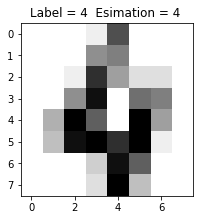

0


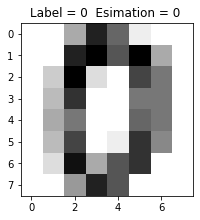

In [28]:
# Randomly select digits and test.
for index in np.random.choice(len(y_test), 2, replace = False):
    print(index)
    predicted = fitted_model.predict(X_test[index:index + 1])[0]
    label = y_test[index]
    title = "Label = %d  Esimation = %d " % (label, predicted)
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()

## 9. Let's save the best model into the Azure ML repository

In [29]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print()
print(fitted_model)
print()
print("Métriques :")
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, '=', metric)

Run(Experiment: Lab2-AutoML,
Id: AutoML_61389ec3-6330-48bd-a1ad-54d557c87bf9_8,
Type: None,
Status: Completed)

Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                    max_features='log2',
                                                                                                    max_leaf_nodes=None,
                                      

In [30]:
for step in fitted_model.named_steps:
    print(step)

datatransformer
prefittedsoftvotingclassifier


In [31]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='mybestmodel',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'AUC': best_run_metrics['AUC_weighted'], 'Accuracy': best_run_metrics['accuracy']})

Model(workspace=Workspace.create(name='AMLworkshop', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='AMLworkshop-rg'), name=mybestmodel, id=mybestmodel:2, version=2, tags={'Training context': 'Azure Auto ML'}, properties={'AUC': '0.9997274913194641', 'Accuracy': '0.9793770912161106'})

In [32]:
# List of all the models from the Azure ML workspace
for model in Model.list(ws):
    print(model.name, '- version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

mybestmodel - version = 2
	 Training context : Azure Auto ML
	 AUC : 0.9997274913194641
	 Accuracy : 0.9793770912161106


IBM_attrition_explainer - version = 2


local_deploy_model - version = 2


DiabetesRidge - version = 3
	 area : Diabetes
	 type : Ridge
	 k : 0.2
	 MSE : 3026.667734128127
	 R2 : 0.4067092393506434
	 RMSE : 55.015159130262695
	 Framework : Azure ML SDK


DiabetesRidge - version = 2
	 area : Diabetes
	 type : Ridge
	 k : 0.2
	 MSE : 3026.667734128127
	 R2 : 0.4067092393506434
	 RMSE : 55.015159130262695
	 Framework : Azure ML SDK


sklearn_mnist - version = 2
	 data : mnist
	 model : classification


TensorFlow - version = 1
	 Framework : TensorFlow
	 Hyperdrive : Yes
	 GPU : Yes


mnistMLmodel - version = 1
	 Source : ONNX


IBM_attrition_explainer - version = 1


local_deploy_model - version = 1


mybestmodel - version = 1
	 Training context : Azure Auto ML
	 AUC : 0.9997251323905743
	 Accuracy : 0.9799660193668762


DiabetesRidge - version = 1
	 area : Diabetes
	 

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">